# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [34]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Read the API keys and configuration variables from the file <root_dir>/.env
from mlfs import config
settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /home/zohra/mlfs-book
HopsworksSettings initialized!


In [35]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util
import os

In [36]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 16, 10, 27, 32, 276265)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [37]:
project = hopsworks.login(engine="python")
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR_LOCATION_JSON_1").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

2025-11-16 10:27:34,338 INFO: Closing external client and cleaning up certificates.
Connection closed.
2025-11-16 10:27:34,361 INFO: Initializing external client
2025-11-16 10:27:34,362 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-16 10:27:35,269 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-16 10:27:35,937 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1279126


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [38]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="air_quality_xgboost_model_v2",
    version=1,
)

fv = retrieved_model.get_feature_view()

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

2025-11-16 10:27:41,683 INFO: Initializing for batch retrieval of feature vectors


Downloading: 0.000%|          | 0/443483 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/452516 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/110543 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/111765 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/20304 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/18686 elapsed<00:00 remaining<?

In [39]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model_v2.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='2.1435389E1', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [40]:
air_quality_fg=fs.get_feature_group(
    name='air_quality',
    version=1,
)
air_quality_df = air_quality_fg.read()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.04s) 


In [41]:
air_quality_df.sort_values("date", ascending=False).head(3)

,date,pm25,country,city,street,url
3722,2025-11-16 00:00:00+00:00,4.0,sweden,stockholm,sollentuna-e4-haggvik,https://api.waqi.info/feed/@7968
3721,2025-11-14 00:00:00+00:00,6.0,sweden,stockholm,sollentuna-e4-haggvik,https://api.waqi.info/feed/@7968
3720,2025-11-13 00:00:00+00:00,5.0,sweden,stockholm,sollentuna-e4-haggvik,https://api.waqi.info/feed/@7968


In [42]:
def recursive_predict_with_rolling_3(model, air_quality_df, batch_data):
   

    # Make sure historical data is ordered from most recent to oldest
    hist = air_quality_df.sort_values("date", ascending=False).copy()

    # last 3 *real* pm25 values (most recent first)
    history = list(hist["pm25"].iloc[:3])

    batch_sorted = batch_data.sort_values("date", ascending=True).copy()

    rolling_means = []

    feature_cols = [
        "rolling_mean",
        "temperature_2m_mean",
        "precipitation_sum",
        "wind_speed_10m_max",
        "wind_direction_10m_dominant",
    ]

    for _, row in batch_sorted.iterrows():
    
        window = history[:3]
        rolling_mean = sum(window) / len(window)
        rolling_means.append(rolling_mean)

        # --- build features for this horizon ---
        row_features = row.copy()
        row_features["rolling_mean"] = rolling_mean
        
        X = row_features[feature_cols].to_frame().T
        X = X.astype(float)

        y_hat = model.predict(X)[0]

        history = [y_hat] + history[:2]

    batch_sorted["rolling_mean"] = rolling_means

    # put back in original order if needed
    return batch_sorted.sort_index()


In [43]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
batch_data = weather_fg.filter(weather_fg.date >= today).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.61s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2025-11-17 00:00:00+00:00,0.80,0.0,16.434305,331.189301,stockholm
1,2025-11-18 00:00:00+00:00,-0.10,0.0,7.568566,272.726257,stockholm
2,2025-11-19 00:00:00+00:00,-0.35,1.1,6.877790,353.991089,stockholm
3,2025-11-20 00:00:00+00:00,-1.50,0.0,8.161764,311.423584,stockholm
4,2025-11-22 00:00:00+00:00,1.15,0.0,17.786331,215.942200,stockholm
5,2025-11-21 00:00:00+00:00,-4.55,0.0,5.771239,273.576263,stockholm


In [44]:
batch_data = recursive_predict_with_rolling_3(
    model=retrieved_xgboost_model,
    air_quality_df=air_quality_df,
    batch_data=batch_data,
)

batch_data


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,rolling_mean
0,2025-11-17 00:00:00+00:00,0.80,0.0,16.434305,331.189301,stockholm,5.000000
1,2025-11-18 00:00:00+00:00,-0.10,0.0,7.568566,272.726257,stockholm,7.018973
2,2025-11-19 00:00:00+00:00,-0.35,1.1,6.877790,353.991089,stockholm,11.434898
3,2025-11-20 00:00:00+00:00,-1.50,0.0,8.161764,311.423584,stockholm,17.232194
4,2025-11-22 00:00:00+00:00,1.15,0.0,17.786331,215.942200,stockholm,25.176823
5,2025-11-21 00:00:00+00:00,-4.55,0.0,5.771239,273.576263,stockholm,22.107246


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [45]:
batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(
    batch_data[['rolling_mean','temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant']])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,rolling_mean,predicted_pm25
0,2025-11-17 00:00:00+00:00,0.80,0.0,16.434305,331.189301,stockholm,5.000000,11.056919
1,2025-11-18 00:00:00+00:00,-0.10,0.0,7.568566,272.726257,stockholm,7.018973,19.247776
2,2025-11-19 00:00:00+00:00,-0.35,1.1,6.877790,353.991089,stockholm,11.434898,21.391886
3,2025-11-20 00:00:00+00:00,-1.50,0.0,8.161764,311.423584,stockholm,17.232194,25.682077
4,2025-11-22 00:00:00+00:00,1.15,0.0,17.786331,215.942200,stockholm,25.176823,24.479452
5,2025-11-21 00:00:00+00:00,-4.55,0.0,5.771239,273.576263,stockholm,22.107246,28.456507


In [46]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6 entries, 0 to 5
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         6 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          6 non-null      float32                
 2   precipitation_sum            6 non-null      float32                
 3   wind_speed_10m_max           6 non-null      float32                
 4   wind_direction_10m_dominant  6 non-null      float32                
 5   city                         6 non-null      object                 
 6   rolling_mean                 6 non-null      float64                
 7   predicted_pm25               6 non-null      float32                
dtypes: datetime64[us, Etc/UTC](1), float32(5), float64(1), object(1)
memory usage: 312.0+ bytes


### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [47]:
batch_data['street'] = street
batch_data['city'] = city
batch_data['country'] = country
# Fill in the number of days before the date on which you made the forecast (base_date)
batch_data['days_before_forecast_day'] = range(1, len(batch_data)+1)
batch_data = batch_data.sort_values(by=['date'])
batch_data

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,rolling_mean,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-17 00:00:00+00:00,0.80,0.0,16.434305,331.189301,stockholm,5.000000,11.056919,sollentuna-e4-haggvik,sweden,1
1,2025-11-18 00:00:00+00:00,-0.10,0.0,7.568566,272.726257,stockholm,7.018973,19.247776,sollentuna-e4-haggvik,sweden,2
2,2025-11-19 00:00:00+00:00,-0.35,1.1,6.877790,353.991089,stockholm,11.434898,21.391886,sollentuna-e4-haggvik,sweden,3
3,2025-11-20 00:00:00+00:00,-1.50,0.0,8.161764,311.423584,stockholm,17.232194,25.682077,sollentuna-e4-haggvik,sweden,4
5,2025-11-21 00:00:00+00:00,-4.55,0.0,5.771239,273.576263,stockholm,22.107246,28.456507,sollentuna-e4-haggvik,sweden,6
4,2025-11-22 00:00:00+00:00,1.15,0.0,17.786331,215.942200,stockholm,25.176823,24.479452,sollentuna-e4-haggvik,sweden,5


In [48]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6 entries, 0 to 4
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         6 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          6 non-null      float32                
 2   precipitation_sum            6 non-null      float32                
 3   wind_speed_10m_max           6 non-null      float32                
 4   wind_direction_10m_dominant  6 non-null      float32                
 5   city                         6 non-null      object                 
 6   rolling_mean                 6 non-null      float64                
 7   predicted_pm25               6 non-null      float32                
 8   street                       6 non-null      object                 
 9   country                      6 non-null      object                 
 10  days_before

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

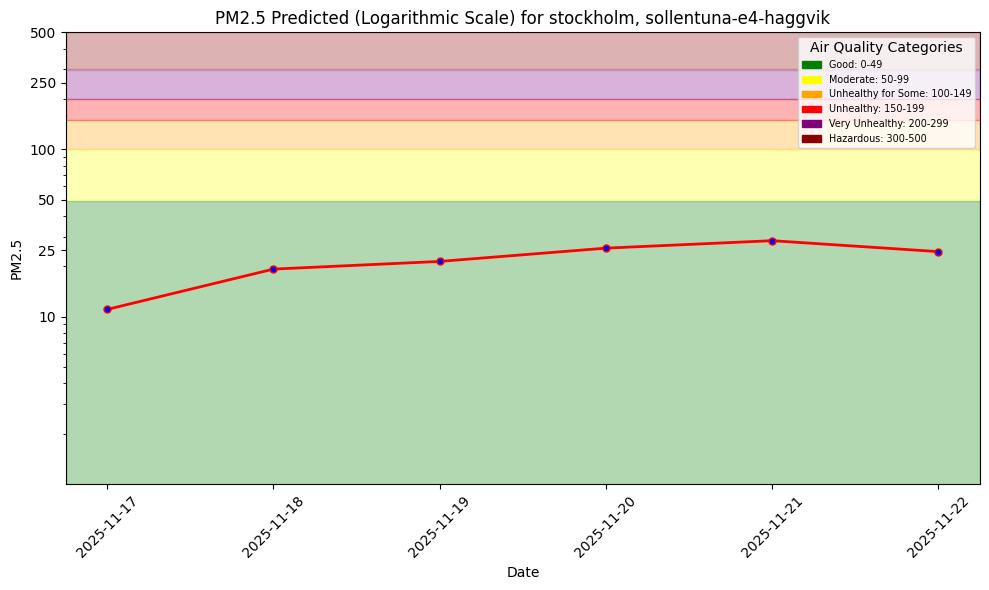

In [49]:

pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast_v2.png"
plt = util.plot_air_quality_forecast(city, street, batch_data, pred_file_path)

plt.show()

In [50]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=2,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [51]:
monitor_fg.insert(batch_data, wait=True)

Uploading Dataframe: 100.00% |█| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time


Launching job: aq_predictions_2_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1279126/jobs/named/aq_predictions_2_offline_fg_materialization/executions
2025-11-16 10:28:38,672 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-16 10:28:45,051 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-16 10:30:20,496 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-16 10:30:20,652 INFO: Waiting for log aggregation to finish.
2025-11-16 10:30:29,242 INFO: Execution finished successfully.


(Job('aq_predictions_2_offline_fg_materialization', 'SPARK'), None)

In [52]:
# We will create a hindcast chart for  only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.00s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,rolling_mean,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-13 00:00:00+00:00,10.0,0.2,16.071491,254.407120,stockholm,12.666667,14.115458,sollentuna-e4-haggvik,sweden,1
1,2025-11-14 00:00:00+00:00,3.0,0.0,11.275530,286.699310,stockholm,11.666667,17.937868,sollentuna-e4-haggvik,sweden,1
2,2025-11-15 00:00:00+00:00,1.6,0.0,10.446206,268.025116,stockholm,8.333333,17.052755,sollentuna-e4-haggvik,sweden,1
3,2025-11-17 00:00:00+00:00,0.8,0.0,16.434305,331.189301,stockholm,5.000000,11.056919,sollentuna-e4-haggvik,sweden,1


In [53]:
air_quality_fg_v2 = fs.get_feature_group(name='air_quality', version=2)
air_quality_df_v2 = air_quality_fg_v2.read()
air_quality_df_v2

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.10s) 


,date,pm25,country,city,street,url,rolling_mean
0,2021-10-16 00:00:00+00:00,5.0,sweden,stockholm,sollentuna-e4-haggvik,https://api.waqi.info/feed/@7968,9.666667
1,2024-03-14 00:00:00+00:00,41.0,sweden,stockholm,sollentuna-e4-haggvik,https://api.waqi.info/feed/@7968,28.666666
2,2016-09-09 00:00:00+00:00,18.0,sweden,stockholm,sollentuna-e4-haggvik,https://api.waqi.info/feed/@7968,11.333333
3,2024-01-31 00:00:00+00:00,14.0,sweden,stockholm,sollentuna-e4-haggvik,https://api.waqi.info/feed/@7968,26.333334
4,2015-09-08 00:00:00+00:00,5.0,sweden,stockholm,sollentuna-e4-haggvik,https://api.waqi.info/feed/@7968,8.666667
...,...,...,...,...,...,...,...
3712,2025-11-11 00:00:00+00:00,16.0,sweden,stockholm,sollentuna-e4-haggvik,https://api.waqi.info/feed/@7968,26.333334
3713,2025-11-12 00:00:00+00:00,14.0,sweden,stockholm,sollentuna-e4-haggvik,https://api.waqi.info/feed/@7968,12.666667
3714,2025-11-13 00:00:00+00:00,5.0,sweden,stockholm,sollentuna-e4-haggvik,https://api.waqi.info/feed/@7968,12.666667
3715,2025-11-14 00:00:00+00:00,6.0,sweden,stockholm,sollentuna-e4-haggvik,https://api.waqi.info/feed/@7968,11.666667


In [54]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df =  monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring_v2(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

,date,predicted_pm25,pm25
0,2025-11-13 00:00:00+00:00,14.115458,5.0
1,2025-11-14 00:00:00+00:00,17.937868,6.0


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

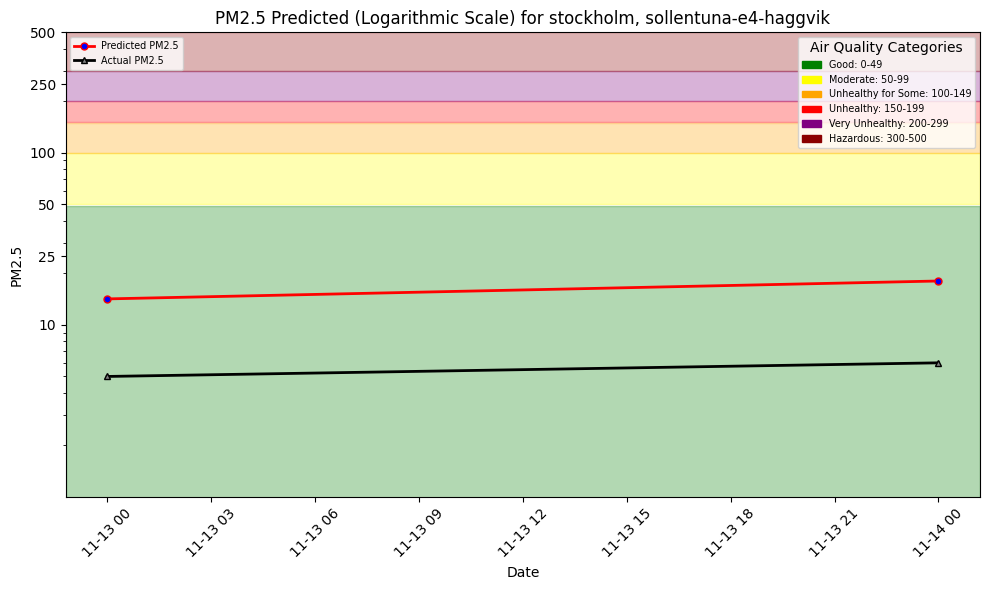

In [55]:
hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day_v2.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)
plt.show()

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [56]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")
dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}_v2", overwrite=True)
dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}_v2", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality_v2")

Uploading /home/zohra/mlfs-book/docs/air-quality/assets/img/pm25_forecast_v2.png: 0.000%|          | 0/45043 e…

Uploading /home/zohra/mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1day_v2.png: 0.000%|          | 0/47…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1279126/settings/fb/path/Resources/airquality_v2


---